In [11]:
# | default_exp repcrp
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Extension: Repetition Lag-CRP
The lag-CRP measures the probability of recalling an item at a particular lag **given the current recall position**, conditional on items that remain available for recall. Here we follow up on our previous repetition-robust implementation of the Lag-CRP analysis with a new implementation that allows us to calculate the **Repetition Lag-CRP**.

In this analysis, we compare transition probabilities from repeated items to items studied near either their first or second presentation (or additional presentations if there are more). This means:

1. We only tabulate lag-transitions from recalls of repeated items (though we still have to track available and actual transitions across trials to accomplish this).
2. We separately tabulate lag-transitions relative to each presentation of the repeated item, so that we can calculate the Lag-CRP for each presentation of the repeated item.

This analysis helps investigate whether transitions from repeated items during free recall are particularly likely to cluster around the first or later presentations of the repeated item, clarifying how item repetition affects the structure of episodic memory search.

## Approach

Our approach extends the repetition-robust implementation of the Lag-CRP analysis by adding a new `RepCRPTabulation` class that extends our existing `crp.Tabulation` class, which is used to tabulate the available and actual transitions for the Lag-CRP analysis. The `RepCRPTabulation` class is designed to 1) exclusively tabulate transitions from repeated items, and 2) separately tabulate transitions for each presentation of the repeated item. This allows us to calculate the Lag-CRP for each repetition index of repeated items.

To exclusively focus on transitions from repeated items, we add a `RepCRPTabulation.should_tabulate` method that `tabulate` uses to determine based on the previous recalled item whether to tabulate the current recalled item or just update the available transitions (and the previous recalled item) to reflect the current recalled item.

To separately tabulate a lag-CRP for each study position index of repeated items, first we use two-dimensional representations of `avail_lags` and `actual_lags`.
In our original repetition-robust implementation of the lag-CRP analysis, our `tabulate_actual_lags` and `tabulate_available_lags` methods collapsed lag identification across study positions of previously recalled items into a single dimension, where the index of the lag was the lag value and the value at that index was `True` if that lag was made from the last recalled item to the current recalled item.
For this implementation, we simply do not collapse the lag identification into a single dimension, and instead use a 2-D array of lags, where the first dimension is the study position of the last recalled item and the second dimension is the lag value.
This resulting representation of lags is a 2-D array of booleans, where the first dimension is the study position of the last recalled item and the second dimension is the lag value.
We can then use this 2-D array to tabulate the actual and available transitions for each lag at each recall attempt, and finally aggregate the counts of actual and available transitions across all trials to get the Lag-CRP for each lag.

A new `min_lag` parameter is added across the implementation to allow the user to specify a minimum amount of serial lag between first and second presentations of repeated items as a filter for inclusion in the analysis.

In [12]:
# | exports
from typing import Optional, Sequence

from jax import jit, lax, vmap
from jax import numpy as jnp
from matplotlib import rcParams  # type: ignore
from matplotlib.axes import Axes
from simple_pytree import Pytree

from jaxcmr.experimental.plotting import init_plot, plot_data, set_plot_labels
from jaxcmr.experimental.repetition import all_study_positions
from jaxcmr.helpers import apply_by_subject
from jaxcmr.typing import Array, Bool, Float, Int_, Integer

In [13]:
# | exports


def set_false_at_index(vec: Bool[Array, " positions"], i: Int_):
    return lax.cond(i, lambda: (vec.at[i - 1].set(False), None), lambda: (vec, None))


class RepCRPTabulation(Pytree):
    "A tabulation of transitions between items during recall of a study list."

    def __init__(
        self,
        presentation: Integer[Array, " study_events"],
        first_recall: Int_,
        min_lag: int = 4,
        size: int = 3,
    ):
        self.size = size
        self.min_lag = min_lag
        self.list_length = presentation.size
        self.lag_range = self.list_length - 1
        self.all_positions = jnp.arange(1, self.list_length + 1, dtype=int)
        self.base_lags = jnp.zeros(self.lag_range * 2 + 1, dtype=int)
        self.item_study_positions = lax.map(
            lambda i: all_study_positions(i, presentation, size),
            self.all_positions,
        )

        self.actual_lags = jnp.zeros((size, self.lag_range * 2 + 1), dtype=int)
        self.avail_lags = jnp.zeros((size, self.lag_range * 2 + 1), dtype=int)

        self.previous_positions = self.item_study_positions[first_recall - 1]
        self.avail_recalls = jnp.ones(self.list_length, dtype=bool)
        self.avail_recalls = self.available_recalls_after(first_recall)

    # for updating avail_recalls: study positions still available for retrieval
    def available_recalls_after(self, recall: Int_) -> Bool[Array, " positions"]:
        "Update the study positions available to retrieve after a transition."
        study_positions = self.item_study_positions[recall - 1]
        return lax.scan(set_false_at_index, self.avail_recalls, study_positions)[0]

    # for updating actual_lags: lag-transitions actually made from the previous item
    def lags_from_previous(self, pos: Int_) -> Bool[Array, " size positions"]:
        "Identify the lag(s) from the study position(s) of the previous item."

        def f(prev):
            return lax.cond(
                (pos * prev) == 0,
                lambda: self.base_lags,
                lambda: self.base_lags.at[pos - prev + self.lag_range].add(1),
            )

        # modified to not sum over prev_recall axis before returning
        return lax.map(f, self.previous_positions).astype(bool)

    def tabulate_actual_lags(self, recall: Int_) -> Integer[Array, " lags"]:
        "Tabulate the actual transition after a transition."
        recall_study_positions = self.item_study_positions[recall - 1]

        # modified to sum over current_recall axis while still separating over prev_recall
        new_lags = lax.map(self.lags_from_previous, recall_study_positions).astype(bool)
        return self.actual_lags + new_lags.sum(0)

    # for updating avail_lags: lag-transitions available from the previous item
    def available_lags_from(self, pos: Int_) -> Bool[Array, " lags"]:
        "Identify recallable lag transitions from the specified study position."
        return lax.cond(
            pos == 0,
            lambda: self.base_lags,
            lambda: self.base_lags.at[self.all_positions - pos + self.lag_range].add(
                self.avail_recalls
            ),
        )

    def tabulate_available_lags(self) -> Integer[Array, " lags"]:
        "Tabulate available transitions after a transition."

        # modified to not sum over prev_recall axis before summing
        new_lags = lax.map(self.available_lags_from, self.previous_positions)
        return self.avail_lags + new_lags.astype(bool)

    # unifying tabulation of actual/avail lags, previous positions, and avail recalls
    def should_tabulate(self) -> Bool:
        "Only consider transitions from item with at least two spaced-out study positions"
        return (
            len(self.previous_positions) > 1
            and self.previous_positions[-1] - self.previous_positions[-2] > self.min_lag
        )

    def conditional_tabulate(self, recall: Int_) -> "RepCRPTabulation":
        "Only tabulate actual and possible lags if the additional condition is met."
        return lax.cond(
            self.should_tabulate(),
            lambda: self.replace(
                previous_positions=self.item_study_positions[recall - 1],
                avail_recalls=self.available_recalls_after(recall),
                actual_lags=self.tabulate_actual_lags(recall),
                avail_lags=self.tabulate_available_lags(),
            ),
            lambda: self.replace(
                previous_positions=self.item_study_positions[recall - 1],
                avail_recalls=self.available_recalls_after(recall),
            ),
        )

    def tabulate(self, recall: Int_) -> "RepCRPTabulation":
        "Tabulate actual and possible serial lags of current from previous item."
        return lax.cond(
            recall,
            lambda: self.conditional_tabulate(recall),
            lambda: self,
        )

Just like in our original implementation, we include a `tabulate_trial` method that takes a trial and updates the `RepCRPTabulation` object with the actual and available transitions for each lag at each recall attempt. Unlike the previous implementation, we directly return actual and available lag tabulations across the trial.

In [14]:
# | exports


def tabulate_trial(
    trial: Integer[Array, " recall_events"],
    presentation: Integer[Array, " study_events"],
    min_lag=4,
    size: int = 2,
) -> tuple[Float[Array, " lags"], Float[Array, " lags"]]:
    init = RepCRPTabulation(presentation, trial[0], min_lag, size)
    tab = lax.fori_loop(1, trial.size, lambda i, t: t.tabulate(trial[i]), init)
    return tab.actual_lags, tab.avail_lags

Finally, in our `repcrp` function, we aggregate the counts of actual and available transitions across all trials, and divide the actual transitions by the available transitions to get the Repetition Lag-CRP for each lag and each repetition index. 

In [15]:
# | export


def repcrp(
    trials: Integer[Array, "trials recall_events"],
    presentation: Integer[Array, "trials study_events"],
    list_length: int,
    min_lag=4,
    size: int = 2,
) -> Float[Array, " lags"]:
    """Returns lag-CRP centered around each study position of repeated items across trials.

    Args:
        trials: Recall events for each trial.
        presentation: Study events for each trial.
        list_length: Number of study events in each trial; unused.
        min_lag: Minimum amount of study positions between two presentations of an item.
        size: Maximum number of study positions an item can be presented
    """
    actual, possible = vmap(tabulate_trial, in_axes=(0, 0, None, None))(
        trials, presentation, min_lag, size
    )
    return actual.sum(0) / possible.sum(0)

## Plotting

Our `plot_rep_crp` function is similar to the original `plot_crp` function, but draws separate lines for each repetition index of repeated items.

We also include some variations of this analysis. `plot_first_rep_crp` and `plot_second_rep_crp` each plot just the CRP corresponding to the first or second presentation of repeated items, respectively. Furthermore, `plot_difference_rep_crp` plots the difference between first and second presentation CRPs for repeated items, which can help highlight the differences in transition probabilities between the first and second presentations of repeated items.

In [16]:
# | exports


def plot_rep_crp(
    datasets: Sequence[dict[str, jnp.ndarray]] | dict[str, jnp.ndarray],
    trial_masks: Sequence[Bool[Array, " trial_count"]] | Bool[Array, " trial_count"],
    max_lag: int = 5,
    min_lag: int = 4,
    size: int = 2,
    repetition_index: Optional[int] = None,
    color_cycle: Optional[list[str]] = None,
    distances: Optional[Float[Array, "word_count word_count"]] = None,
    labels: Optional[Sequence[str]] = None,
    contrast_name: Optional[str] = None,
    axis: Optional[Axes] = None,
) -> Axes:
    """Returns Axes object with plotted prob of repetition lag-crp for datasets and trial masks.

    Args:
        datasets: Datasets containing trial data to be plotted.
        trial_masks: Masks to filter trials in datasets.
        max_lag: Maximum number of study positions an item can be presented at.
        min_lag: Minimum amount of study positions between two presentations of an item.
        size: Maximum number of study positions an item can be presented at.
        color_cycle: List of colors for plotting each dataset.
        distances: Unused, included for compatibility with other plotting functions.
        labels: Names for each dataset for legend, optional.
        contrast_name: Name of contrast for legend labeling, optional.
        axis: Existing matplotlib Axes to plot on, optional.
    """

    axis = init_plot(axis)

    if color_cycle is None:
        color_cycle = [each["color"] for each in rcParams["axes.prop_cycle"]]

    if labels is None:
        labels = [""] * len(datasets)

    if isinstance(datasets, dict):
        datasets = [datasets]

    if isinstance(trial_masks, jnp.ndarray):
        trial_masks = [trial_masks]

    if isinstance(repetition_index, int):
        repetition_indices = [repetition_index]
    else:
        repetition_indices = list(range(size))

    lag_interval = jnp.arange(-max_lag, max_lag + 1, dtype=int)

    for data_index, data in enumerate(datasets):
        lag_range = jnp.max(data["listLength"][trial_masks[data_index]]) - 1
        subject_values = apply_by_subject(
            data,
            trial_masks[data_index],
            jit(repcrp, static_argnames=("size",)),
            min_lag,
            size,
        )

        # repetition_index = 0
        # repetition_subject_values = jnp.vstack(
        #     [each[repetition_index] for each in subject_values]
        # )[:, lag_range - max_lag : lag_range + max_lag + 1]

        # color = color_cycle.pop(0)
        # plot_data(
        #     axis,
        #     lag_interval,
        #     repetition_subject_values,
        #     str(1),
        #     color,
        # )

        # repetition_subject_values = jnp.zeros_like(repetition_subject_values)
        # for repetition_index in repetition_indices[1:]:
        #     repetition_subject_values = repetition_subject_values + jnp.vstack(
        #         [each[repetition_index] for each in subject_values]
        #     )[:, lag_range - max_lag : lag_range + max_lag + 1]
        # repetition_subject_values = repetition_subject_values / (len(repetition_indices)-1)

        # color = color_cycle.pop(0)
        # plot_data(
        #     axis,
        #     lag_interval,
        #     repetition_subject_values,
        #     str("2+"),
        #     color,
        # )

        for repetition_index in repetition_indices:
            repetition_subject_values = jnp.vstack(
                [each[repetition_index] for each in subject_values]
            )[:, lag_range - max_lag : lag_range + max_lag + 1]

            color = color_cycle.pop(0)
            plot_data(
                axis,
                lag_interval,
                repetition_subject_values,
                str(repetition_index + 1),
                color,
            )

    set_plot_labels(axis, "Lag", "Conditional Resp. Prob.", contrast_name)
    return axis


In [17]:
# | exports


def plot_difference_rep_crp(
    datasets: Sequence[dict[str, jnp.ndarray]] | dict[str, jnp.ndarray],
    trial_masks: Sequence[Bool[Array, " trial_count"]] | Bool[Array, " trial_count"],
    max_lag: int = 5,
    min_lag: int = 4,
    size: int = 2,
    color_cycle: Optional[list[str]] = None,
    distances: Optional[Float[Array, "word_count word_count"]] = None,
    labels: Optional[Sequence[str]] = None,
    contrast_name: Optional[str] = None,
    axis: Optional[Axes] = None,
) -> Axes:
    """Returns Axes object with plotted prob of repetition lag-crp for datasets and trial masks.

    Args:
        datasets: Datasets containing trial data to be plotted.
        trial_masks: Masks to filter trials in datasets.
        max_lag: Maximum number of study positions an item can be presented at.
        min_lag: Minimum amount of study positions between two presentations of an item.
        size: Maximum number of study positions an item can be presented at.
        color_cycle: List of colors for plotting each dataset.
        distances: Unused, included for compatibility with other plotting functions.
        labels: Names for each dataset for legend, optional.
        contrast_name: Name of contrast for legend labeling, optional.
        axis: Existing matplotlib Axes to plot on, optional.
    """

    axis = init_plot(axis)

    if color_cycle is None:
        color_cycle = [each["color"] for each in rcParams["axes.prop_cycle"]]

    if labels is None:
        labels = [""] * len(datasets)

    if isinstance(datasets, dict):
        datasets = [datasets]

    if isinstance(trial_masks, jnp.ndarray):
        trial_masks = [trial_masks]

    lag_interval = jnp.arange(-max_lag, max_lag + 1, dtype=int)

    for data_index, data in enumerate(datasets):
        lag_range = jnp.max(data["listLength"][trial_masks[data_index]]) - 1
        subject_values = apply_by_subject(
            data,
            trial_masks[data_index],
            jit(repcrp, static_argnames=("size",)),
            min_lag,
            size,
        )

        repetition_index = 0
        repetition_subject_values = jnp.vstack(
            [each[repetition_index] for each in subject_values]
        )[:, lag_range - max_lag : lag_range + max_lag + 1]

        repetition_index = 1
        repetition_subject_values -= jnp.vstack(
            [each[repetition_index] for each in subject_values]
        )[:, lag_range - max_lag : lag_range + max_lag + 1]

        color = color_cycle.pop(0)
        plot_data(
            axis,
            lag_interval,
            repetition_subject_values,
            str(repetition_index + 1),
            color,
        )

    set_plot_labels(axis, "Lag", "Diff. Conditional Resp. Prob.", contrast_name)
    return axis


In [18]:
# | export


def plot_first_rep_crp(
    datasets: Sequence[dict[str, jnp.ndarray]] | dict[str, jnp.ndarray],
    trial_masks: Sequence[Bool[Array, " trial_count"]] | Bool[Array, " trial_count"],
    max_lag: int = 5,
    min_lag: int = 4,
    size: int = 2,
    color_cycle: Optional[list[str]] = None,
    distances: Optional[Float[Array, "word_count word_count"]] = None,
    labels: Optional[Sequence[str]] = None,
    contrast_name: Optional[str] = None,
    axis: Optional[Axes] = None,
) -> Axes:
    "Convenience function to plot first repetition CRP."
    return plot_rep_crp(
        datasets,
        trial_masks,
        max_lag,
        min_lag,
        size,
        repetition_index=0,  # first repetition
        color_cycle=color_cycle,
        distances=distances,
        labels=labels,
        contrast_name=contrast_name,
        axis=axis,
    )


def plot_second_rep_crp(
    datasets: Sequence[dict[str, jnp.ndarray]] | dict[str, jnp.ndarray],
    trial_masks: Sequence[Bool[Array, " trial_count"]] | Bool[Array, " trial_count"],
    max_lag: int = 5,
    min_lag: int = 4,
    size: int = 2,
    color_cycle: Optional[list[str]] = None,
    distances: Optional[Float[Array, "word_count word_count"]] = None,
    labels: Optional[Sequence[str]] = None,
    contrast_name: Optional[str] = None,
    axis: Optional[Axes] = None,
) -> Axes:
    "Convenience function to plot first repetition CRP."
    return plot_rep_crp(
        datasets,
        trial_masks,
        max_lag,
        min_lag,
        size,
        repetition_index=1,  # first repetition
        color_cycle=color_cycle,
        distances=distances,
        labels=labels,
        contrast_name=contrast_name,
        axis=axis,
    )

## Examples

In [19]:
import os

from jaxcmr.helpers import find_project_root, generate_trial_mask, load_data

/Users/jordangunn/jaxcmr/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:440: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  return fun(*args, **kwargs)


<Axes: xlabel='Lag', ylabel='Conditional Resp. Prob.'>

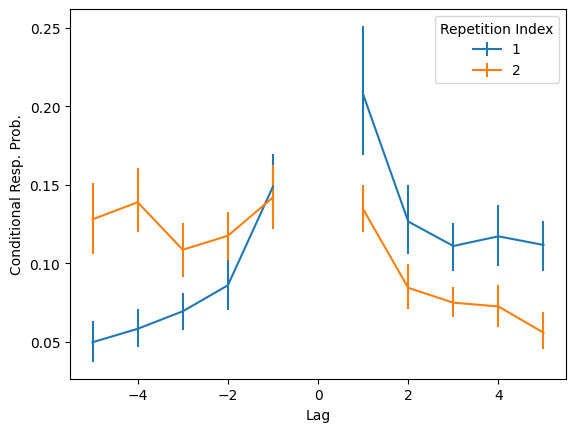

In [20]:
# parameters
run_tag = "RepCRP"
data_name = "LohnasKahana2014"
data_query = "data['list_type'] > 2"
data_path = os.path.join(find_project_root(), "data/LohnasKahana2014.h5")

# set up data structures
data = load_data(data_path)
recalls = data["recalls"]
presentations = data["pres_itemnos"]
list_length = data["listLength"][0].item()
trial_mask = generate_trial_mask(data, data_query)

# plot
plot_rep_crp(
    data,
    generate_trial_mask(data, data_query),
    labels=["First", "Second"],
    contrast_name="Repetition Index",
)
# jit(repcrp, static_argnames=("size", "list_length"))(recalls[trial_mask], presentations[trial_mask], list_length)

/Users/jordangunn/jaxcmr/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:440: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  return fun(*args, **kwargs)


<Axes: xlabel='Lag', ylabel='Conditional Resp. Prob.'>

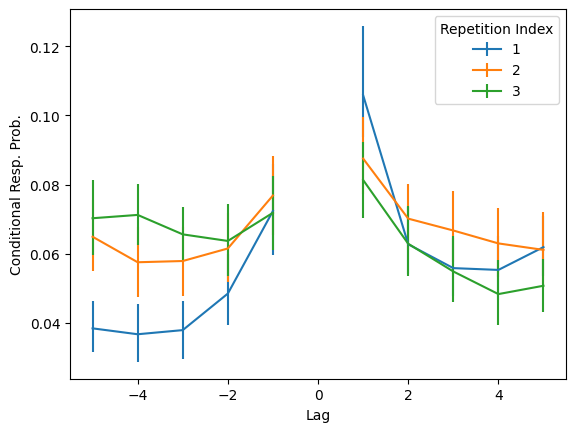

In [ ]:
# parameters
run_tag = "RepCRP"
data_name = "HowardKahana2005"
data_query = "data['condition'] > 0"
data_path = os.path.join(find_project_root(), "data/HowardKahana2005.h5")

# set up data structures
data = load_data(data_path)
recalls = data["recalls"]
presentations = data["pres_itemnos"]
list_length = data["listLength"][0].item()
trial_mask = generate_trial_mask(data, data_query)

# plot
plot_rep_crp(
    data,
    generate_trial_mask(data, data_query),
    contrast_name="Repetition Index",
    size=3,
)
# jit(repcrp, static_argnames=("size", "list_length"))(recalls[trial_mask], presentations[trial_mask], list_length, size=3)

/Users/jordangunn/jaxcmr/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:440: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  return fun(*args, **kwargs)


(0.03, 0.13)

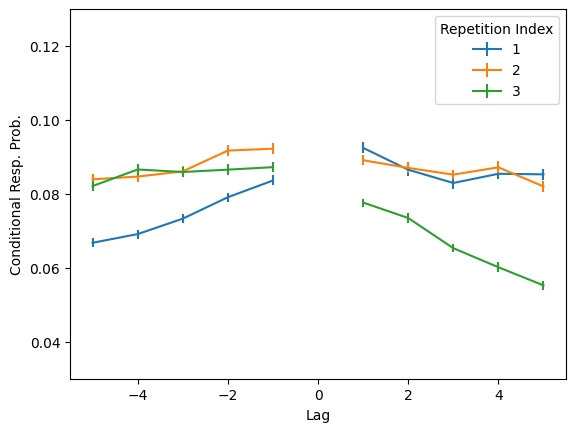

In [48]:
import matplotlib.pyplot as plt

import json
from jax import random
import jax.numpy as jnp
from jaxcmr.simulation import simulate_h5_from_h5
from jaxcmr.weird_cmr import BaseCMRFactory as weird_cmr_model_factory
import numpy as np

seed = 0
experiment_count = 50

data_path = "data/{}.h5"
data_tag = "HowardKahana2005"
trial_query = "data['condition'] > 0"

data = load_data(data_path.format(data_tag))
max_size = np.max(data["pres_itemnos"])
connections = jnp.zeros((max_size, max_size))

fit_path = "fits/HowardKahana2005_WeirdCMR_full_best_of_3.json"
with open(fit_path) as f:
    results = json.load(f)
    if "subject" not in results["fits"]:
        results["fits"]["subject"] = results["subject"]

rng = random.PRNGKey(seed)
rng, rng_iter = random.split(rng)
trial_mask = generate_trial_mask(data, trial_query)
sim = simulate_h5_from_h5(
    model_factory=weird_cmr_model_factory,
    dataset=data,
    connections=connections,
    parameters={key: jnp.array(val) for key, val in results["fits"].items()},  # type: ignore
    trial_mask=trial_mask,
    experiment_count=experiment_count,
    rng=rng_iter,
)

data = {key: jnp.array(value) for key, value in sim.items()}

plot_rep_crp(
    data,
    generate_trial_mask(data, data_query),
    contrast_name="Repetition Index",
    size=3,
)
plt.ylim(0.03, .13)